In [12]:
import os

HOME = os.getcwd()

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/home/thebird/Dynamworks/LLM_Module/Hackathon/weights/sam_vit_h_4b8939.pth ; exist: True


In [2]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/home/thebird/anaconda3/envs/dynamworks_hackathon/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = 

In [3]:
mask_generator = SamAutomaticMaskGenerator(sam)


In [4]:
import cv2
import supervision as sv # pip install supervision==0.24.0

image_bgr = cv2.imread("/home/thebird/Dynamworks/LLM_Module/Hackathon/Vehicle_Detection_Image_Dataset/sample_image.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image_rgb)


In [5]:
print(len(masks))
print(masks[0].keys())


145
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


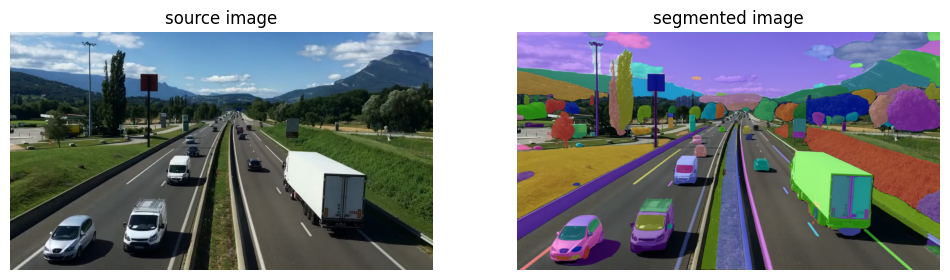

In [6]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

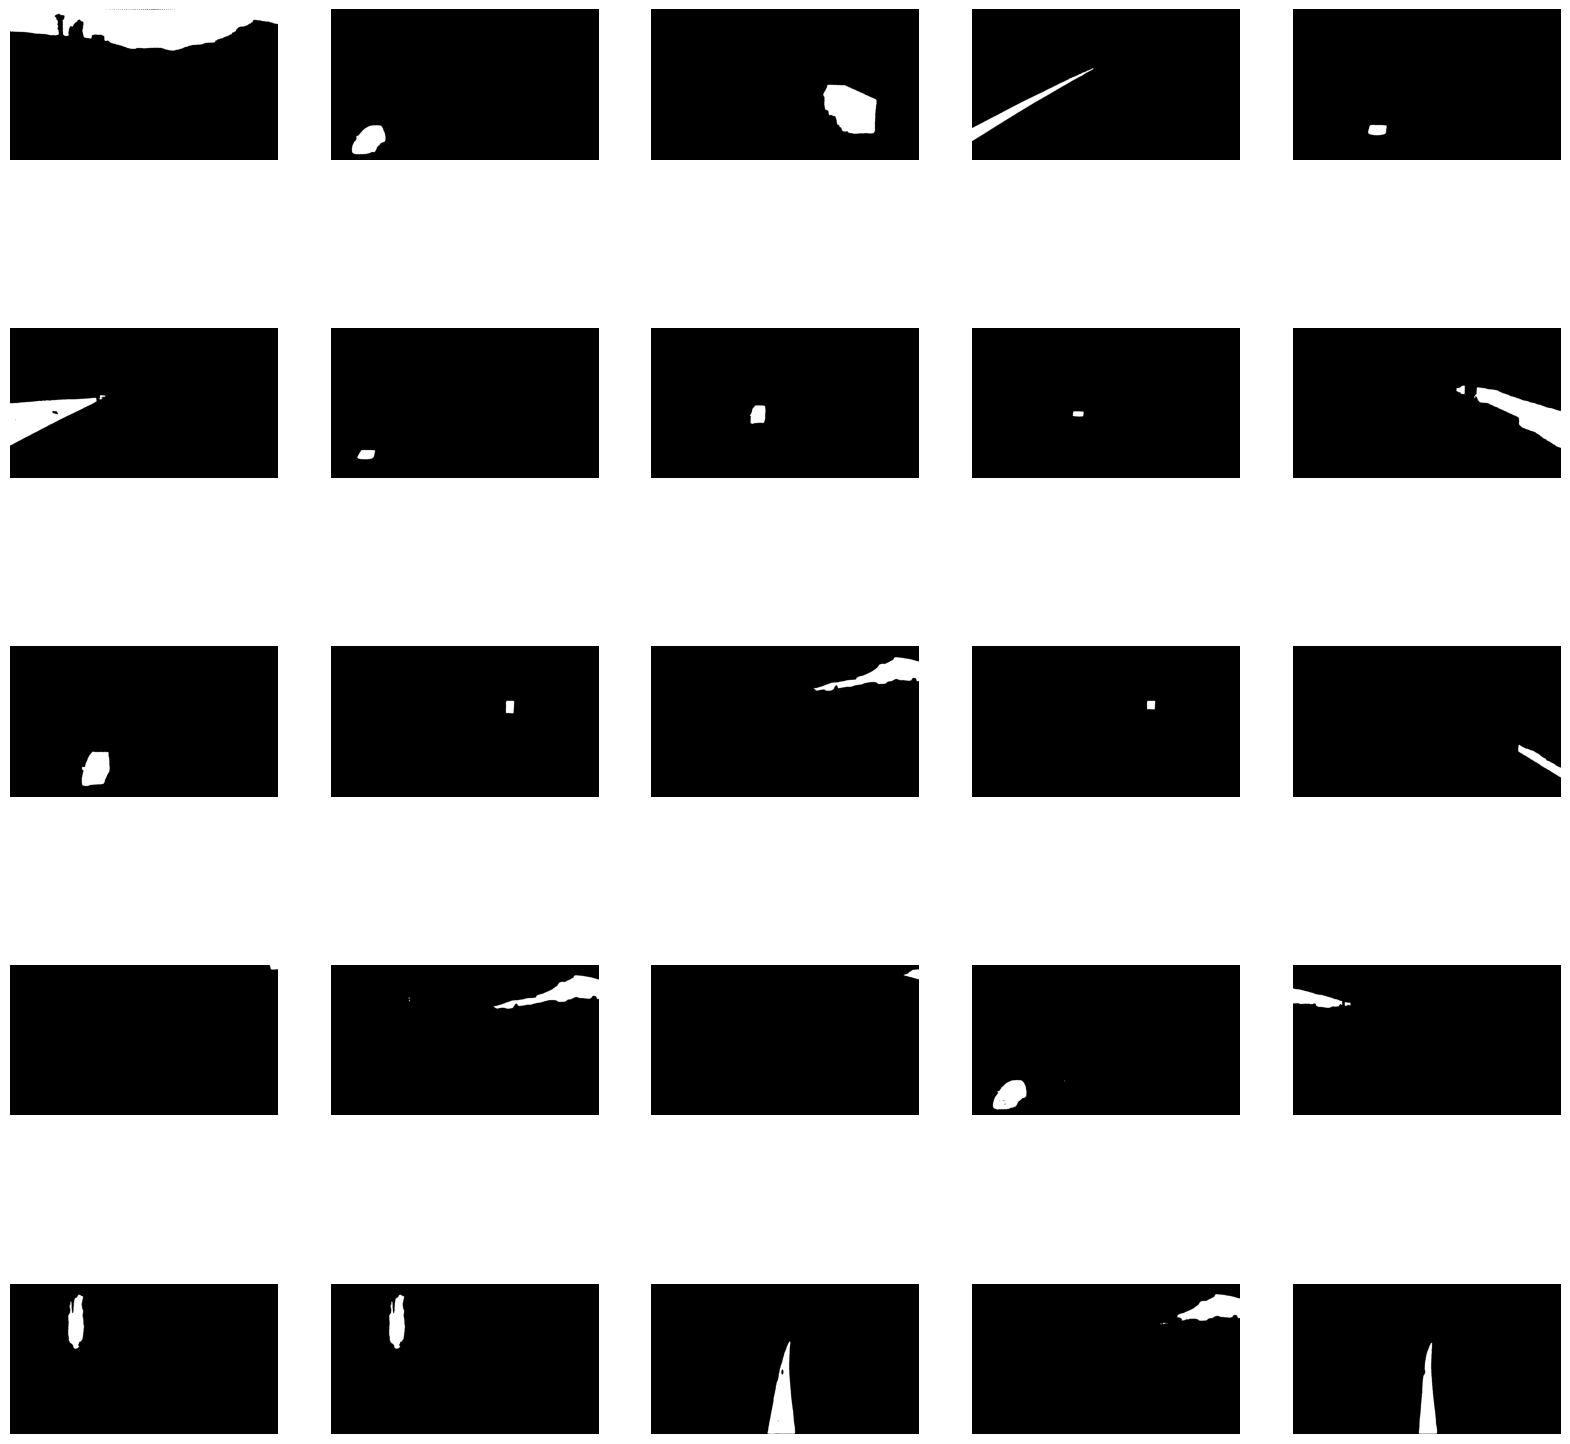

In [7]:
import numpy as np
select_mask  = [mask["segmentation"] for mask in masks[0:25]]

sv.plot_images_grid(
    images=select_mask,
    grid_size= (5,5),
    size=(20,20)
)

In [8]:
from ultralytics import YOLO

from IPython.display import display, Image

model = YOLO('yolov8n.pt')
model.fuse()

YOLOv8n summary (fused): 168 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


In [9]:
mask_predictor = SamPredictor(sam)

In [10]:
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - based on the number of classses
CLASS_ID = [item for item in range(0,len(CLASS_NAMES_DICT))]

CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [ ]:
import cv2
import numpy as np
import torch

# Replace the following line with your actual VIDEO_PATH
VIDEO_PATH = "/home/thebird/Dynamworks/LLM_Module/Hackathon/Vehicle_Detection_Image_Dataset/sample_video.mp4"
OUTPUT_VIDEO_PATH = "/home/thebird/Dynamworks/LLM_Module/Hackathon/working/sample_video_yolo_sam.mp4"

# This will contain the resulting mask predictions for local use
mask_frames = []

def get_video_dimensions(cap):
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    return width, height

def add_color_to_mask(mask, color):
    # Convert the color tensor to CPU
    color = torch.tensor(color).cpu().numpy()

    # Create a binary mask based on the original mask
    color_mask = np.zeros_like(mask.cpu().numpy(), dtype=np.uint8)
    color_mask[mask.cpu().numpy() > 0] = 1  # Set non-zero values to 1

    # Expand the color tensor and apply it to the binary mask
    colored_mask = color_mask[..., None] * color

    return colored_mask

def draw_class_names(frame, class_names, positions, color, font_size=0.5):
    for class_name, position in zip(class_names, positions):
        cv2.putText(frame, class_name, position, cv2.FONT_HERSHEY_SIMPLEX, font_size, color, 2, cv2.LINE_AA)

def draw_yolov8_boxes(frame, boxes, color):
    for box in boxes:
        box = list(map(int, box))
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)

constant_mask_color = np.array([0, 0, 255], dtype=np.uint8)  # Red color for masks
output_class_color = (0, 255, 0)  # Green color for class names
yolov8_box_color = (255, 0, 0)  # Blue color for YOLOv8 bounding boxes

cap = cv2.VideoCapture(VIDEO_PATH)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, 15.0, (width, height))

frame_num = 1
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Check if the frame is empty or None
    if frame is None:
        continue  # Skip processing for empty frames

    # Run frame through YOLOv8 to get detections
    detections = model.predict(frame, conf=0.7)

    # Check if there are fish detections
    if len(detections[0].boxes) == 0:
        continue  # Skip processing for frames without fish detections

    # Run frame and detections through SAM to get masks
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(
        detections[0].boxes.xyxy, list(get_video_dimensions(cap))
    )
    mask_predictor.set_image(frame)
    masks, _, _ = mask_predictor.predict_torch(
        boxes=transformed_boxes,
        multimask_output=False,
        point_coords=None,
        point_labels=None
    )

    # Check if the mask is empty
    if masks[0][0].numel() == 0:
        continue  # Skip processing for empty masks

    # Combine mask predictions into a single mask, each with the same color
    class_ids = detections[0].boxes.cpu().cls
    merged_with_colors = add_color_to_mask(masks[0][0], constant_mask_color)
    for i in range(1, len(masks)):
        curr_mask_with_colors = add_color_to_mask(masks[i][0], constant_mask_color)
        merged_with_colors = np.bitwise_or(merged_with_colors, curr_mask_with_colors)

    # Draw YOLOv8 bounding boxes on the frame
    draw_yolov8_boxes(frame, detections[0].boxes.xyxy, yolov8_box_color)

    # Draw class names on the frame with a slightly larger font
    class_names = [CLASS_NAMES_DICT[int(class_id)] for class_id in class_ids]
    draw_class_names(frame, class_names, [(int(box[0]), int(box[1])) for box in detections[0].boxes.xyxy], output_class_color, font_size=0.7)

    # Overlay the SAM masks onto the frame
    frame_with_masks = cv2.addWeighted(frame, 1, merged_with_colors, 0.5, 0)

    # Write the frame with masks, YOLOv8 boxes, and class names to the output video
    output_video.write(frame_with_masks)

    frame_num += 1

cap.release()
output_video.release()